In [1]:
import pandas as pd
from transformers import DistilBertTokenizerFast
import webdataset as wds
import sys
from utils.utils import GEODataset
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_parquet("data/geo_data.parquet")

In [4]:
texts = df["text"].values.tolist()
labels = df[["lat",  "lon"]].astype(float).values.tolist()

In [13]:
train_ratio = 0.78
test_ratio = 0.17
validation_ratio = 0.5

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(texts, labels, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


In [19]:
len(x_train)/len(texts), len(x_test)/len(texts), len(x_val)/len(texts)

(0.7799994155138563, 0.1641795010082386, 0.0558210834779051)

<AxesSubplot:xlabel='lon', ylabel='lat'>

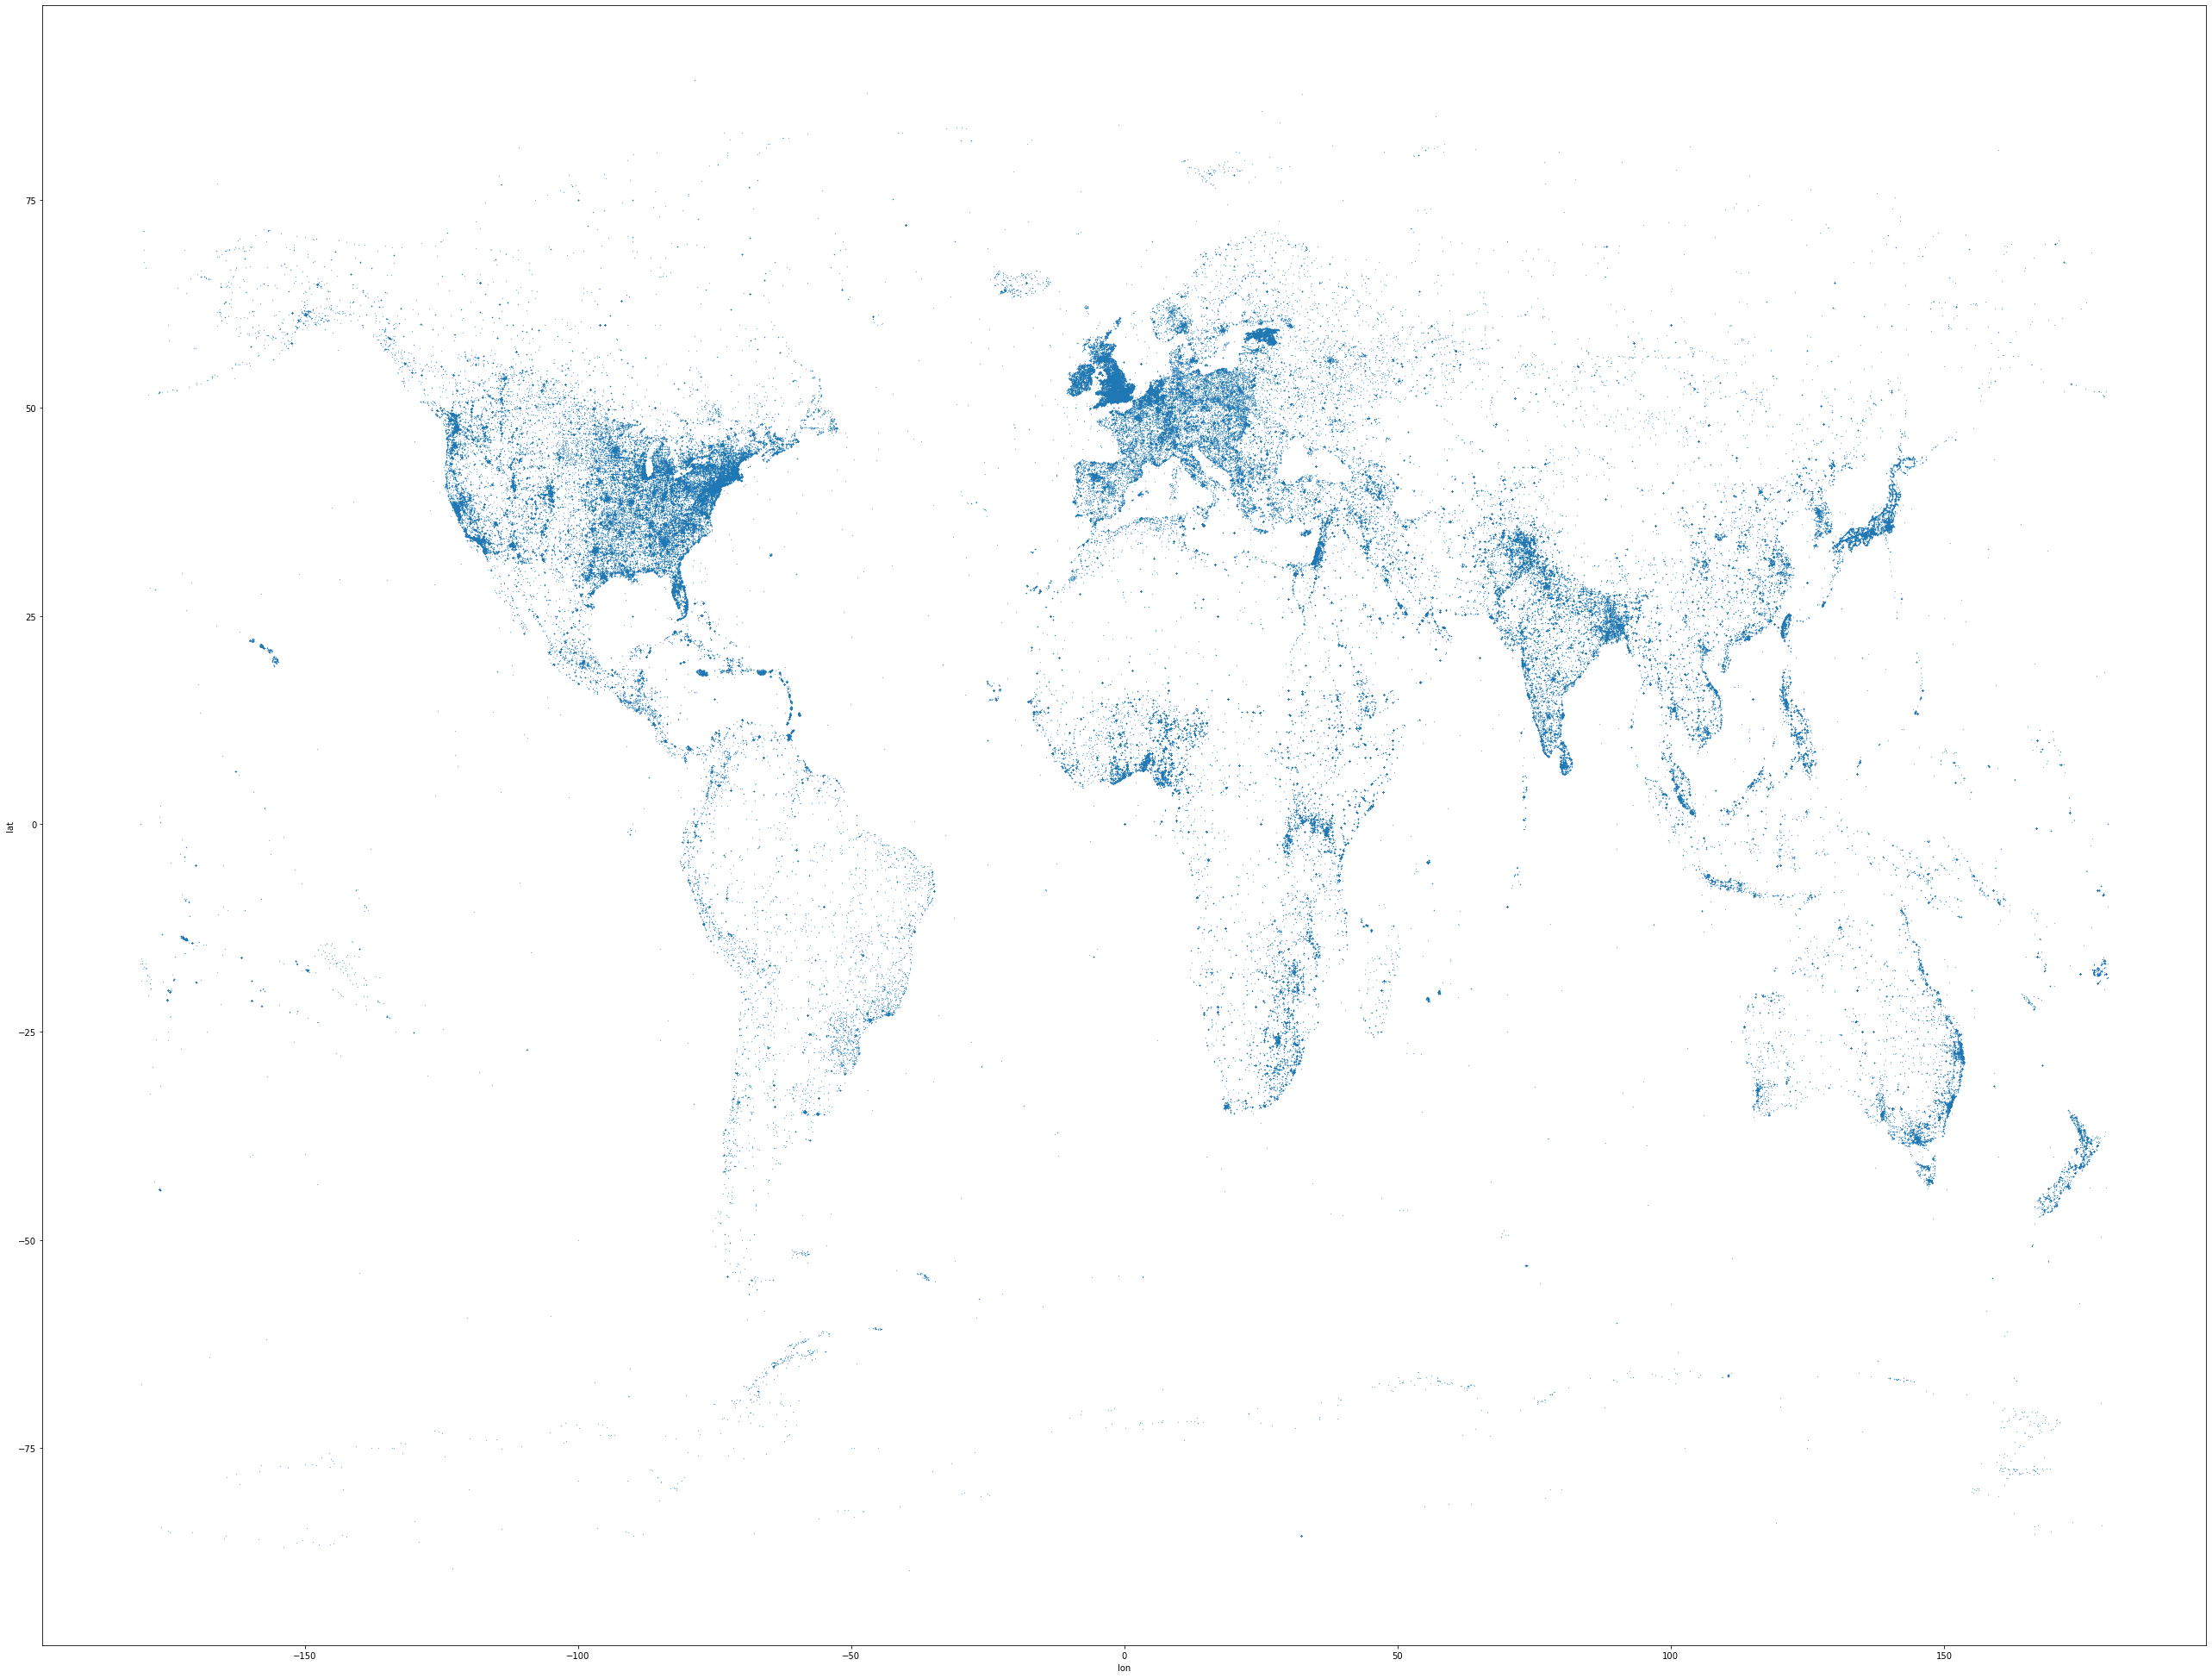

In [5]:
df_sample.plot.scatter(x='lon', y='lat', figsize = (45,35), s=0.05)

In [18]:
TOKEN_MODEL = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(TOKEN_MODEL)

In [20]:
tok_train = tokenizer(x_train, truncation=True, padding=True)

In [21]:
tok_test = tokenizer(x_test, truncation=True, padding=True)

In [22]:
tok_val = tokenizer(x_val, truncation=True, padding=True)

In [16]:
labels_train = y_train
labels_test = y_test
labels_val = y_val

In [23]:
train_dataset = GEODataset(tok_train, labels_train)
test_dataset = GEODataset(tok_test, labels_test)
val_dataset = GEODataset(tok_val, labels_val)

In [26]:
dataset_map = {'train' : train_dataset, 'test': test_dataset, 'val': val_dataset}

In [27]:
for key in dataset_map.keys():
    dataset = dataset_map[key]
    sink = wds.TarWriter(f"data/{key}_geo_wds.tar")
    for index, enc in enumerate(dataset):
        if index%10000==0:
            print(f"{index:6d}", end="\r", flush=True, file=sys.stderr)
        sink.write({
            "__key__": "sample%06d" % index,
            "enc_dict.pyd": enc,
        })
    sink.close()

In [60]:
!ls -l data/geo_wds.tar
!tar tvf data/geo_wds.tar | head

-rw-r--r--  1 hhoferic  staff  3179816960 Nov 19 18:23 data/geo_wds.tar
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000000.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000001.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000002.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000003.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000004.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000005.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000006.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000007.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000008.batch.pyd
-r--r--r--  0 bigdata bigdata  9219 Nov 19 18:21 sample000009.batch.pyd


In [3]:
webds = wds.WebDataset('data/train_geo_wds.tar').decode('torch')

In [4]:
import torch

In [5]:
dataloader = torch.utils.data.DataLoader(webds, num_workers=1, batch_size=16)

In [6]:
for index, batch in enumerate(dataloader):
    if index%10000==0:
        print(batch['enc_dict.pyd']['labels'])

tensor([[  19.5000,  -80.6667],
        [  51.5000,   -0.1167],
        [   3.7667,   47.3000],
        [  39.8282,  -98.5795],
        [  44.2563,  -89.6385],
        [  46.8167,    9.8333],
        [  51.5000,   10.5000],
        [  25.5000,   51.2500],
        [   1.3667,  103.8000],
        [  25.3500,   83.0500],
        [   8.0000,   -2.0000],
        [  46.0000,   25.0000],
        [  56.8000,   -4.9833],
        [   1.3667,  103.8000],
        [  44.2394, -114.5100],
        [  39.2143,  -78.1825]])
tensor([[ 41.5834, -72.7622],
        [ 32.7673, -89.6812],
        [ 42.5200,  12.5153],
        [ 51.9333,  16.0500],
        [ 38.8951, -77.0364],
        [ 37.5664, 127.0000],
        [ 42.9873, -72.5540],
        [ 54.0000,  -2.0000],
        [ 39.9671, -74.9427],
        [ 39.8833, -78.3664],
        [ 32.2193,  63.8080],
        [-10.0000, -55.0000],
        [ 54.0000,  -4.0000],
        [ 27.8333, -81.7170],
        [ 55.7522,  37.6156],
        [ 39.8647, -86.2604]])


KeyboardInterrupt: 